# Spaceship Titanic

The Problem

Welcome to the year 2912; data science skills are needed to solve a cosmic mystery. 
The Spaceship Titanic was an interstellar passenger liner launched a month ago. With almost 13,000 passengers on board, the vessel set out on its maiden voyage transporting emigrants from our solar system to three newly habitable exoplanets orbiting nearby stars.
While rounding Alpha Centauri en route to its first destination—the torrid 55 Cancri E—the unwary Spaceship Titanic collided with a spacetime anomaly hidden within a dust cloud. Sadly, it met a similar fate as its namesake 1000 years before. Though the ship stayed intact, almost half of the passengers were transported to an alternate dimension!

To help rescue crews and retrieve the lost passengers, you are challenged to predict which passengers were transported by the anomaly to an alternative dimension using records recovered from the spaceship’s damaged computer system.
Help save them and change history!


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pycaret.datasets import get_data
from pycaret.classification import *
import missingno

## Data Preparation

In [2]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

In [3]:
train.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


* **train.csv** - Personal records for about two-thirds (~8700) of the passengers, to be used as training data.
* **PassengerId** - A unique Id for each passenger. Each Id takes the form gggg_pp where gggg indicates a group the passenger is travelling with and pp is their number within the group. People in a group are often family members, but not always.
* **HomePlanet** - The planet the passenger departed from, typically their planet of permanent residence.
* **CryoSleep** - Indicates whether the passenger elected to be put into suspended animation for the duration of the voyage. Passengers in cryosleep are confined to their cabins.
* **Cabin** - The cabin number where the passenger is staying. Takes the form deck/num/side, where side can be either P for Port or S for Starboard.
* **Destination** - The planet the passenger will be debarking to.
* **Age** - The age of the passenger.
* **VIP** - Whether the passenger has paid for special VIP service during the voyage.
* **RoomService, FoodCourt, ShoppingMall, Spa, VRDeck** - Amount the passenger has billed at each of the Spaceship Titanic's many luxury amenities.
* **Name** - The first and last names of the passenger.
* **Transported** - Whether the passenger was transported to another dimension. This is the target, the column you are trying to predict.

In [4]:
test.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name
0,0013_01,Earth,True,G/3/S,TRAPPIST-1e,27.0,False,0.0,0.0,0.0,0.0,0.0,Nelly Carsoning
1,0018_01,Earth,False,F/4/S,TRAPPIST-1e,19.0,False,0.0,9.0,0.0,2823.0,0.0,Lerome Peckers
2,0019_01,Europa,True,C/0/S,55 Cancri e,31.0,False,0.0,0.0,0.0,0.0,0.0,Sabih Unhearfus
3,0021_01,Europa,False,C/1/S,TRAPPIST-1e,38.0,False,0.0,6652.0,0.0,181.0,585.0,Meratz Caltilter
4,0023_01,Earth,False,F/5/S,TRAPPIST-1e,20.0,False,10.0,0.0,635.0,0.0,0.0,Brence Harperez


In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 891.5+ KB


### Missing Value Analysis

Missing Data and Missing Data pattern:
We will analyse the distribution of missing data in the train and test dataset.

In [6]:
train.isnull().sum().sort_values(ascending=False)/len(train)

CryoSleep       0.024963
ShoppingMall    0.023927
VIP             0.023352
HomePlanet      0.023122
Name            0.023007
Cabin           0.022892
VRDeck          0.021627
FoodCourt       0.021051
Spa             0.021051
Destination     0.020936
RoomService     0.020821
Age             0.020591
PassengerId     0.000000
Transported     0.000000
dtype: float64

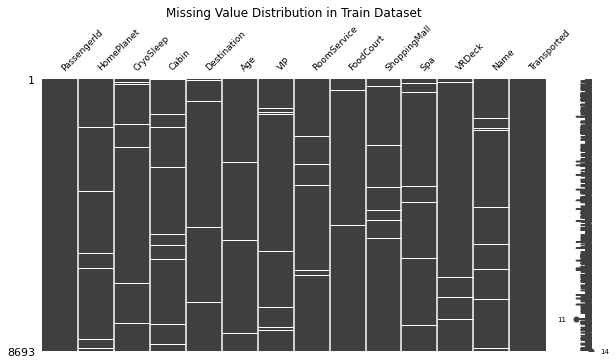

In [7]:
missingno.matrix(train,figsize=(10,5), fontsize=9)
plt.title("Missing Value Distribution in Train Dataset");

The matrix above shows that we have missing data pattern all columns except in PassengerId and target variable Transported. We can also see that the missing data are not localized to the same set of observations. Though each column has less than 3% missing value individually, we cannot drop all rows with missing data using dropna() without losing substantial info from the dataset. The missing data will be imputed with the most effective method feature by feature basis and will be handled in the wrangle function.

In [8]:
test.isnull().sum().sort_values(ascending=False)/len(test)

FoodCourt       0.024784
Spa             0.023615
Cabin           0.023381
ShoppingMall    0.022913
Name            0.021978
CryoSleep       0.021744
VIP             0.021744
Destination     0.021510
Age             0.021277
HomePlanet      0.020341
RoomService     0.019172
VRDeck          0.018705
PassengerId     0.000000
dtype: float64

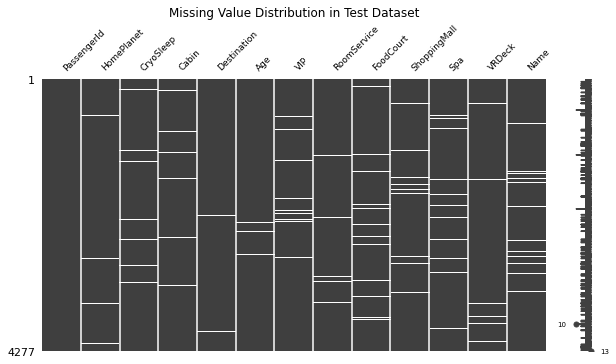

In [9]:
missingno.matrix(test,figsize=(10,5), fontsize=9)
plt.title("Missing Value Distribution in Test Dataset");

### Identify & Handle Outliers

In [10]:
train.describe()

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
count,8514.000000,8512.000000,8510.000000,8485.000000,8510.000000,8505.000000
mean,28.827930,224.687617,458.077203,173.729169,311.138778,304.854791
std,14.489021,666.717663,1611.489240,604.696458,1136.705535,1145.717189
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,19.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,27.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,38.000000,47.000000,76.000000,27.000000,59.000000,46.000000
max,79.000000,14327.000000,29813.000000,23492.000000,22408.000000,24133.000000


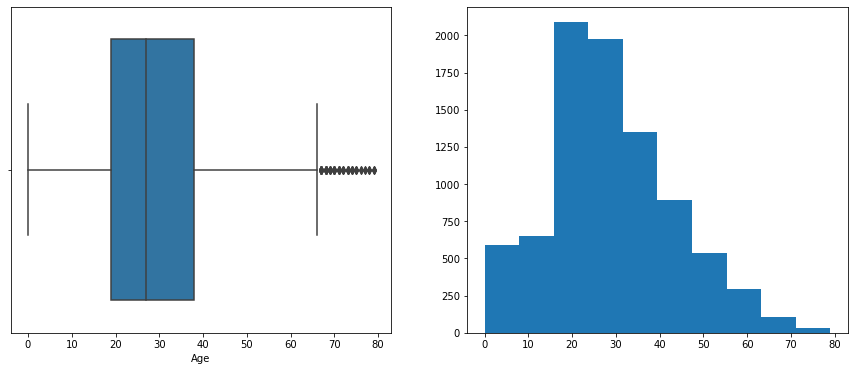

In [11]:
fig,ax = plt.subplots(1,2, figsize=(15,6))
sns.boxplot(x= train["Age"], ax=ax[0])
plt.hist(train["Age"]);

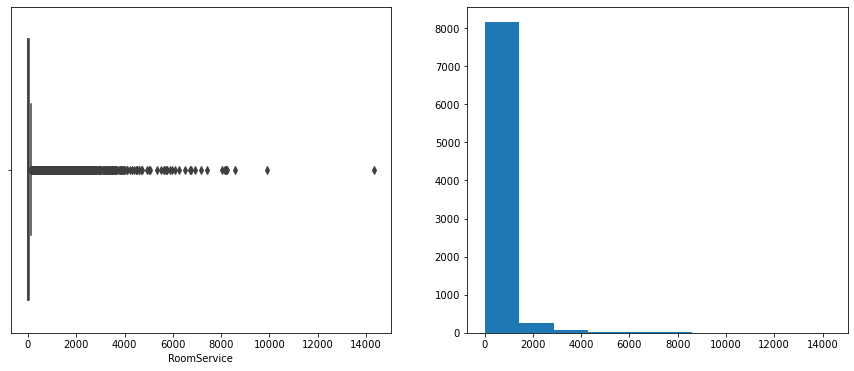

In [12]:
fig,ax = plt.subplots(1,2, figsize=(15,6))
sns.boxplot(x= train["RoomService"], ax=ax[0])
plt.hist(train["RoomService"]);

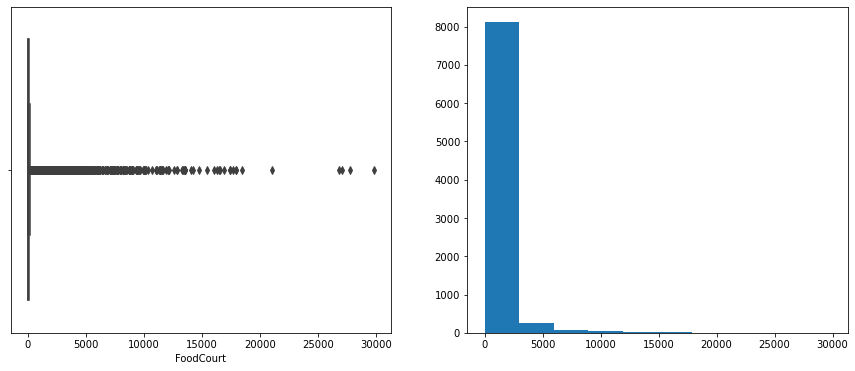

In [13]:
fig,ax = plt.subplots(1,2, figsize=(15,6))
sns.boxplot(x= train["FoodCourt"], ax=ax[0])
plt.hist(train["FoodCourt"]);

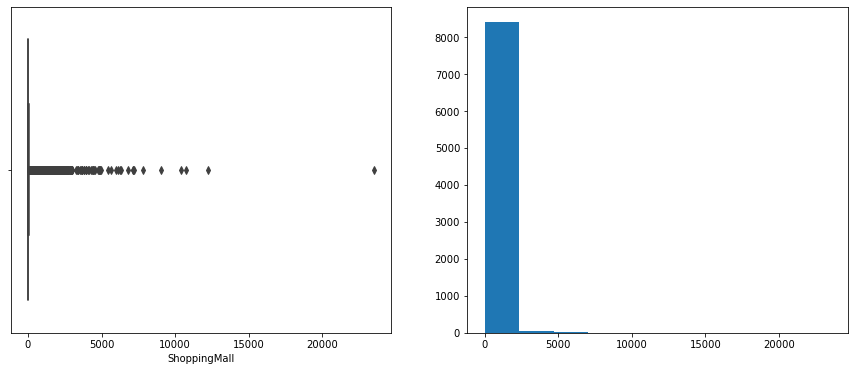

In [14]:
fig,ax = plt.subplots(1,2, figsize=(15,6))
sns.boxplot(x= train["ShoppingMall"], ax=ax[0])
plt.hist(train["ShoppingMall"]);

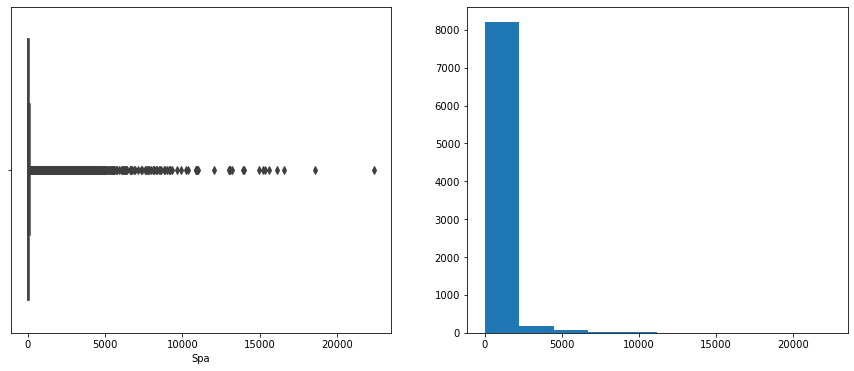

In [15]:
fig,ax = plt.subplots(1,2, figsize=(15,6))
sns.boxplot(x= train["Spa"], ax=ax[0])
plt.hist(train["Spa"]);

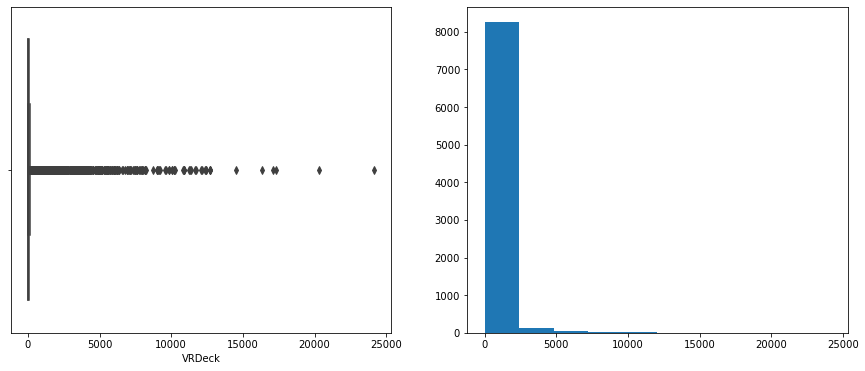

In [16]:
fig,ax = plt.subplots(1,2, figsize=(15,6))
sns.boxplot(x= train["VRDeck"], ax=ax[0])
plt.hist(train["VRDeck"]);

Looking at the data carefully, we noticed that not a lot of passengers spent money on luxury services. The few that spent on such services look like outliers in the dataset but for this analysis the extreme values will not removed. A number of passenger typically spend huge sums on services when aboard cruise ships and similar trend exists here. We will examine if this set of passengers have other attributes in common


### Identify Features with High Cardinality and Multicolinearity

In [17]:
train.select_dtypes("object").nunique()

PassengerId    8693
HomePlanet        3
CryoSleep         2
Cabin          6560
Destination       3
VIP               2
Name           8473
dtype: int64

Analyzed the data for cardinality. Cabin column can be split to expose port and starboard side of the ship which can definitely impact evacuation. PassengerId and Name have high cardinality and hence be dropped. A firther look at the name column to determine the gender of the passenger was done but no good method identified to generalize the gender based on the name.

In [18]:
correlation = train.select_dtypes("number").corr()
correlation

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
Age,1.000000,0.068723,0.130421,0.033133,0.123970,0.101007
RoomService,0.068723,1.000000,-0.015889,0.054480,0.010080,-0.019581
FoodCourt,0.130421,-0.015889,1.000000,-0.014228,0.221891,0.227995
ShoppingMall,0.033133,0.054480,-0.014228,1.000000,0.013879,-0.007322
Spa,0.123970,0.010080,0.221891,0.013879,1.000000,0.153821
VRDeck,0.101007,-0.019581,0.227995,-0.007322,0.153821,1.000000


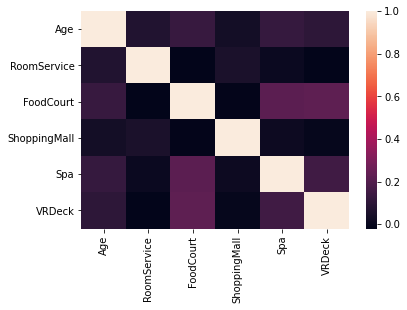

In [19]:
sns.heatmap(correlation);

There is no strong correlations between any two feature variables. Thus, we will not be dropping any column for multicilinearity issue in this analysis.

A wrangle function is defined to centralize the data cleaning process.

In [20]:
def wrangle(filepath):
    # Read csv file into dataFrame
    df = pd.read_csv(filepath)
    
    # Split column Cabin into Deck,Num and Side
    df["deck"] = df["Cabin"].str.split("/", expand = True)[0]
    df["Num"] = df["Cabin"].str.split("/", expand = True)[1]
    df["Side"] = df["Cabin"].str.split("/", expand = True)[2]
    df.drop(columns="Cabin",inplace=True)
    
    # Create Passenger Group for pax traveling as a group
    df["PaxInGroup"] = df["PassengerId"].str.split("_",expand=True)[0].astype(int).duplicated(keep=False)
    
    # Fill missing data
    df['Age'].fillna(df['Age'].mean(), inplace=True)
    df['Spa'].fillna(df['Spa'].median(), inplace=True)
    df['VRDeck'].fillna(df['VRDeck'].median(), inplace=True)
    df['RoomService'].fillna(df['RoomService'].median(), inplace=True)
    df['FoodCourt'].fillna(df['FoodCourt'].median(), inplace=True)
    df['ShoppingMall'].fillna(df['ShoppingMall'].median(), inplace=True)
    df = df.fillna(df.agg(lambda x: pd.Series.mode(x)[0], axis=0))
    
   
    # Convert bool to 0,1
    df["CryoSleep"] = df["CryoSleep"].astype(bool)
    df["VIP"] = df["VIP"].astype(bool)
    
    # Drop multicolinearity column
    
    # Drop columns with high cardinality
    df.drop(columns=["Name","Num"],inplace=True)
    
    return df

In [21]:
data = wrangle("train.csv")
data.head()

,PassengerId,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,deck,Side,PaxInGroup
0,0001_01,Europa,False,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,False,B,P,False
1,0002_01,Earth,False,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,True,F,S,False
2,0003_01,Europa,False,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,False,A,S,True
3,0003_02,Europa,False,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,False,A,S,True
4,0004_01,Earth,False,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,True,F,S,False


In [22]:
data.drop(columns="PassengerId",inplace=True)

In [23]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   HomePlanet    8693 non-null   object 
 1   CryoSleep     8693 non-null   bool   
 2   Destination   8693 non-null   object 
 3   Age           8693 non-null   float64
 4   VIP           8693 non-null   bool   
 5   RoomService   8693 non-null   float64
 6   FoodCourt     8693 non-null   float64
 7   ShoppingMall  8693 non-null   float64
 8   Spa           8693 non-null   float64
 9   VRDeck        8693 non-null   float64
 10  Transported   8693 non-null   bool   
 11  deck          8693 non-null   object 
 12  Side          8693 non-null   object 
 13  PaxInGroup    8693 non-null   bool   
dtypes: bool(4), float64(6), object(4)
memory usage: 713.2+ KB


## Exploring Relationships Between Categorical Features

In [24]:
data.select_dtypes("object").nunique()

HomePlanet     3
Destination    3
deck           8
Side           2
dtype: int64

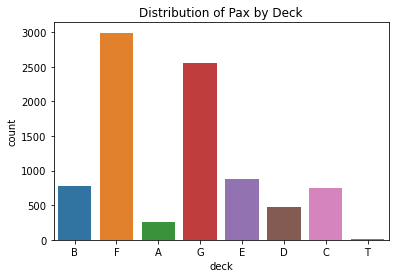

In [25]:
sns.countplot(data= data, x="deck")
plt.title("Distribution of Pax by Deck");

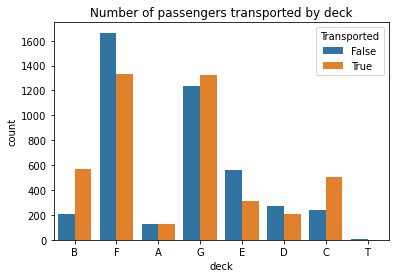

In [26]:
sns.countplot(hue="Transported", x="deck", data=data)
plt.title('Number of passengers transported by deck');

<AxesSubplot:xlabel='Side', ylabel='count'>

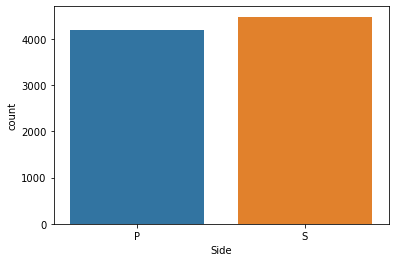

In [27]:
sns.countplot(data= data, x="Side")

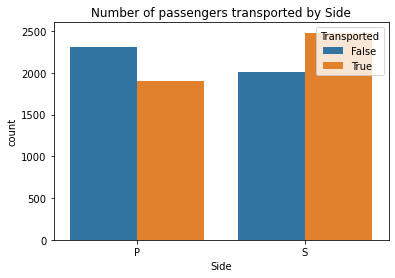

In [28]:
sns.countplot(hue="Transported", x="Side", data=data)
plt.title('Number of passengers transported by Side');

<AxesSubplot:xlabel='Destination', ylabel='count'>

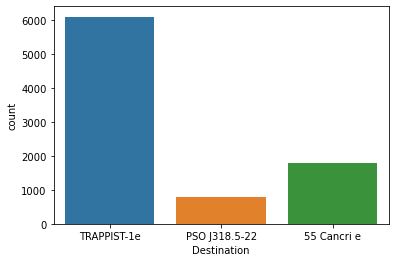

In [29]:
sns.countplot(data= data, x="Destination")

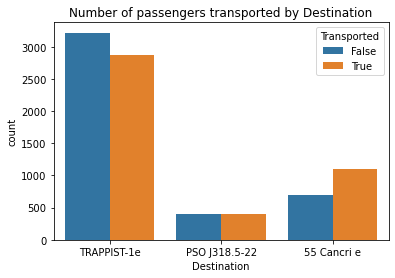

In [30]:
sns.countplot(hue="Transported", x="Destination", data=data)
plt.title('Number of passengers transported by Destination');

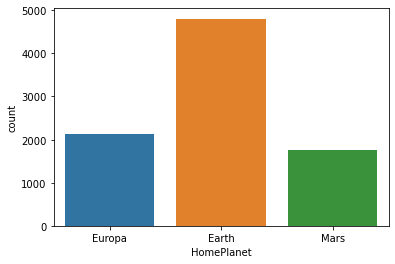

In [31]:
sns.countplot(data= data, x="HomePlanet");

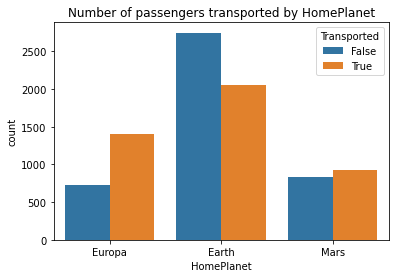

In [32]:
sns.countplot(hue="Transported", x="HomePlanet", data=data)
plt.title('Number of passengers transported by HomePlanet');

<AxesSubplot:xlabel='CryoSleep', ylabel='count'>

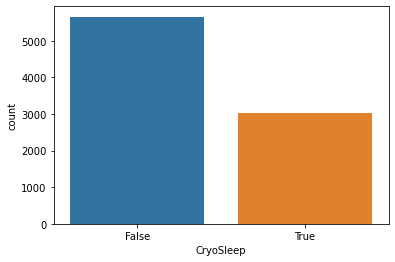

In [33]:
sns.countplot(data= data, x="CryoSleep")

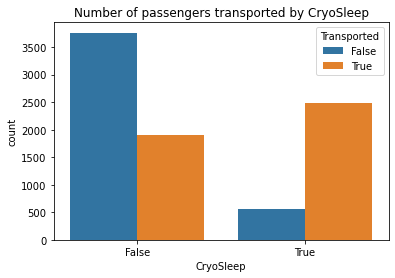

In [34]:
sns.countplot(hue="Transported", x="CryoSleep", data=data)
plt.title('Number of passengers transported by CryoSleep');

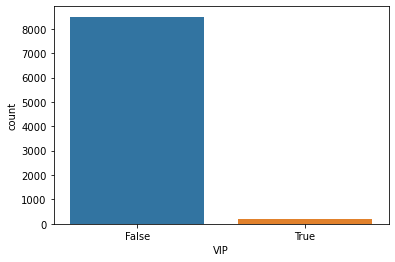

In [35]:
sns.countplot(data= data, x="VIP");

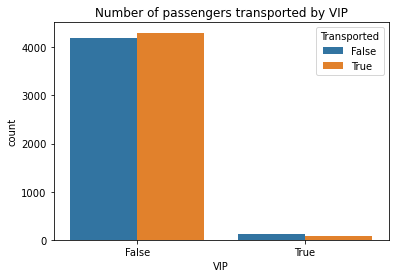

In [36]:
sns.countplot(hue="Transported", x="VIP", data=data)
plt.title('Number of passengers transported by VIP');

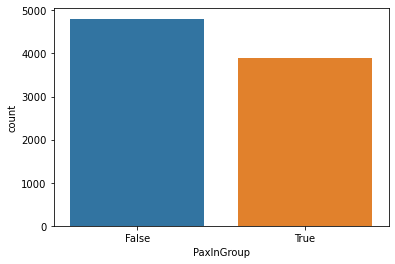

In [37]:
sns.countplot(data= data, x="PaxInGroup");

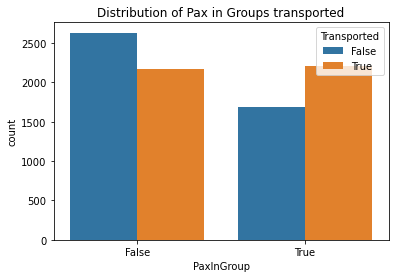

In [38]:
sns.countplot(hue="Transported", x="PaxInGroup", data=data)
plt.title('Distribution of Pax in Groups transported');

Various relationships exist between the plotted categorical features and target. 
* More pax were transported from Deck B, C & G. Deck B and C have a relatively higher ratio of pax transported compared to pax on other decks. 
* Pax on the Port side of the ship were transported in higher number than thos on the Starboard. 
* Passengers whose destinations was 55 Cancri e saw a better chance of being transported compared to other destinations.
* Passengers from HomePlanet Europa got transported to the alternate dimension in higher ratio relative to the other other HomePlanets.
* Cryosleep seems to be a big factor in weather a passenger get transported or not. More than 75% of passengers in CryoSleep got transported.
* Finally we saw a higher chance of passengers that travel with a group(mostly friends and family) to be transported compared to those without companions. 

## Exploring Relationships Between Numerical Features

In [39]:
data.corr()

,CryoSleep,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,PaxInGroup
CryoSleep,1.000000,-0.070736,-0.078281,-0.244089,-0.205928,-0.207798,-0.198307,-0.192721,0.460132,0.091562
Age,-0.070736,1.000000,0.091574,0.068425,0.127343,0.032846,0.121071,0.099551,-0.074249,-0.133769
VIP,-0.078281,0.091574,1.000000,0.056566,0.125499,0.018412,0.060991,0.123061,-0.037261,0.034027
RoomService,-0.244089,0.068425,0.056566,1.000000,-0.015126,0.052337,0.009244,-0.018624,-0.241124,-0.019338
FoodCourt,-0.205928,0.127343,0.125499,-0.015126,1.000000,-0.013717,0.221468,0.224572,0.045583,0.066683
ShoppingMall,-0.207798,0.032846,0.018412,0.052337,-0.013717,1.000000,0.014542,-0.007849,0.009391,-0.029095
Spa,-0.198307,0.121071,0.060991,0.009244,0.221468,0.014542,1.000000,0.147658,-0.218545,0.043639
VRDeck,-0.192721,0.099551,0.123061,-0.018624,0.224572,-0.007849,0.147658,1.000000,-0.204874,0.044293
Transported,0.460132,-0.074249,-0.037261,-0.241124,0.045583,0.009391,-0.218545,-0.204874,1.000000,0.113792
PaxInGroup,0.091562,-0.133769,0.034027,-0.019338,0.066683,-0.029095,0.043639,0.044293,0.113792,1.000000


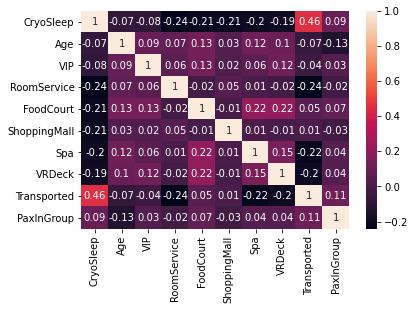

In [40]:
sns.heatmap(data.corr().round(decimals=2), annot=True);

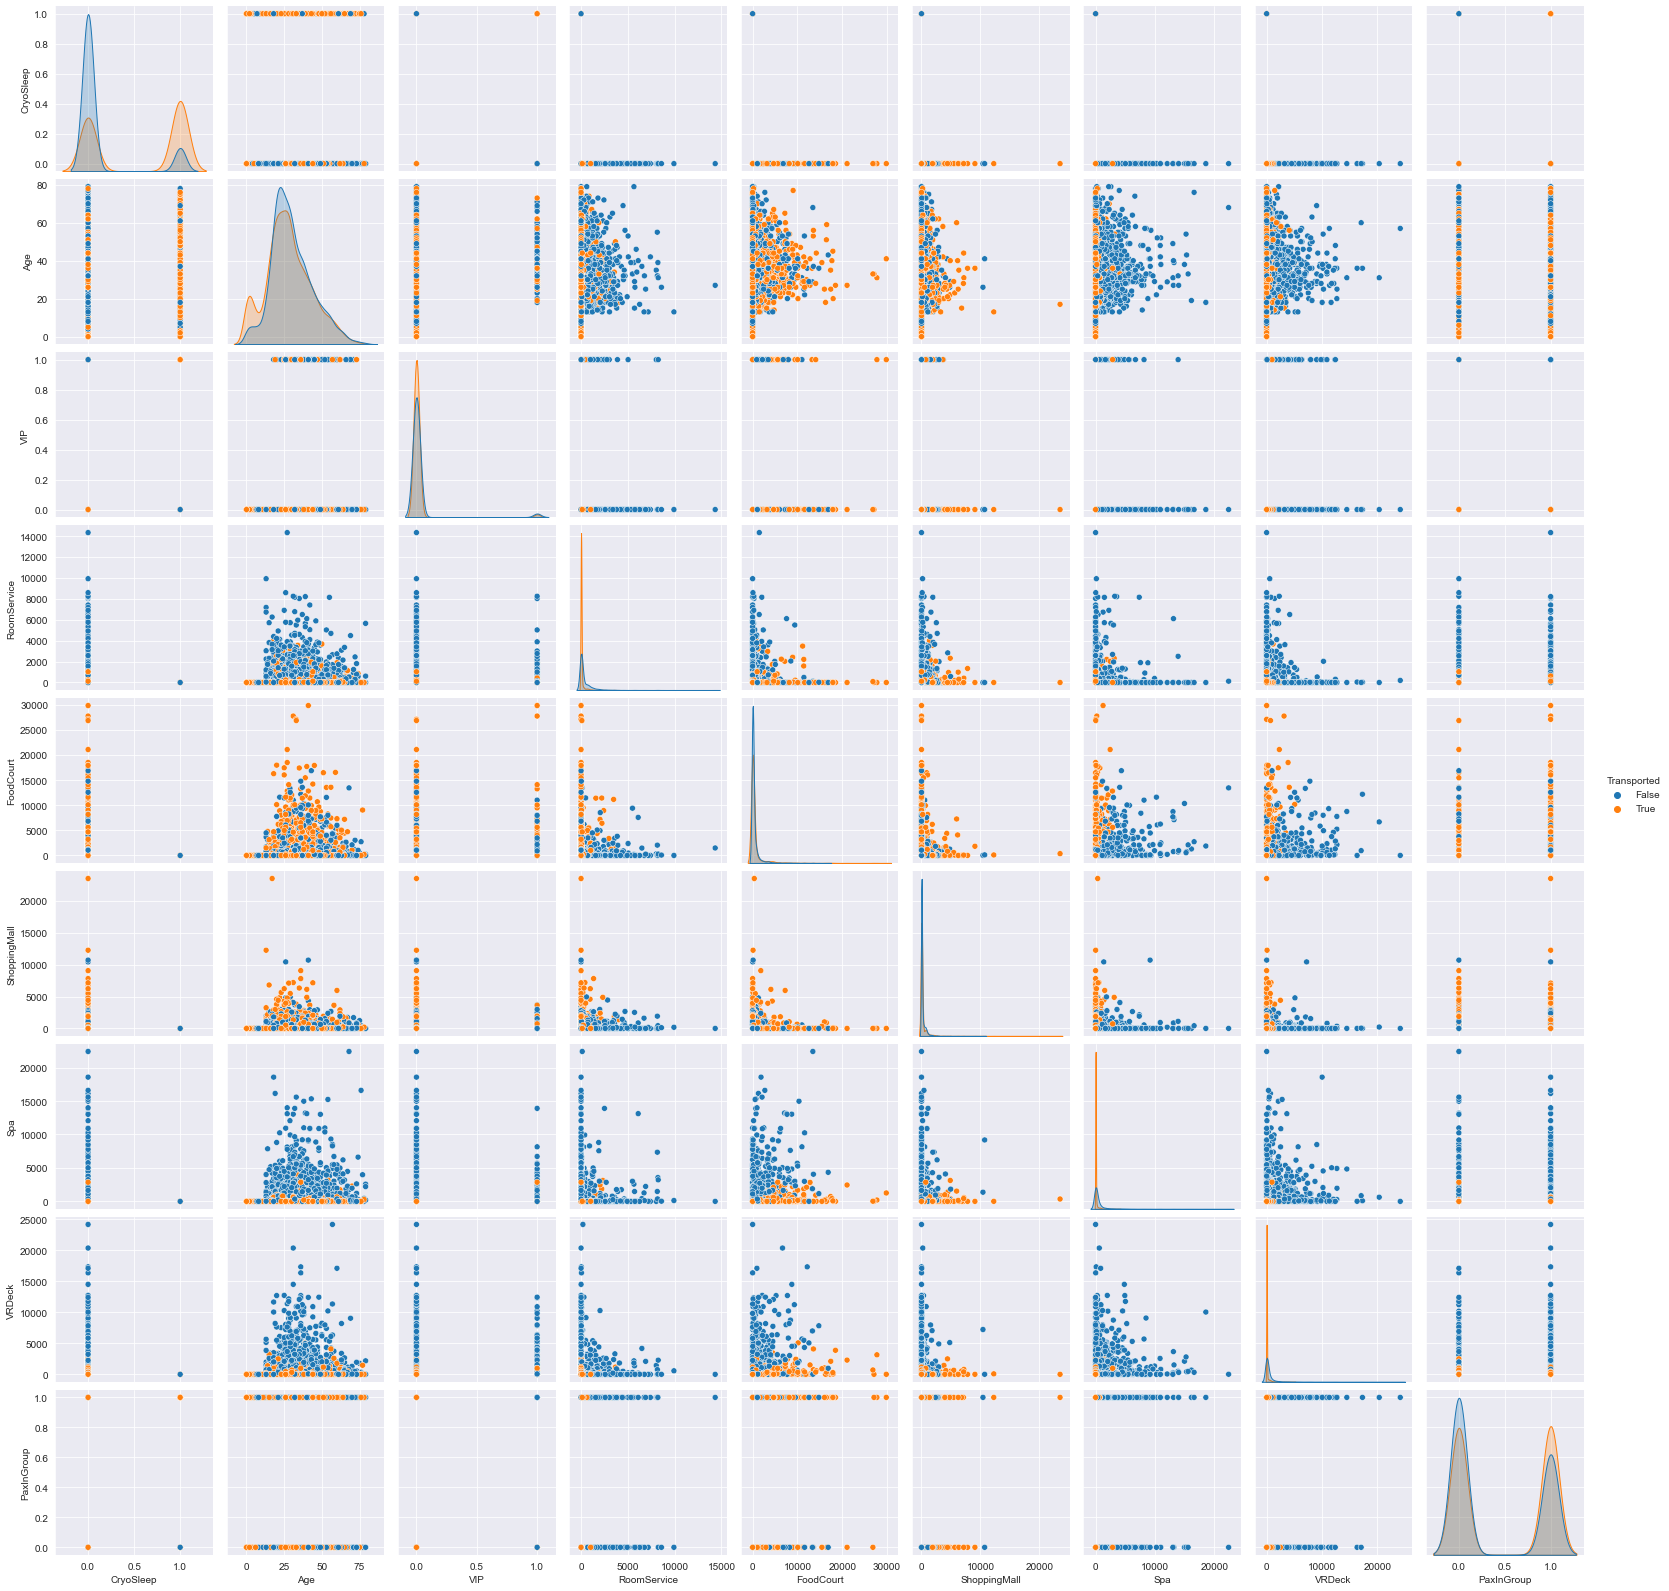

In [41]:
sns.set_style('darkgrid') 
sns.pairplot(data, hue = 'Transported') 
plt.show()

The strongest relationship exists between the CryoSleep feature and the target. Most of the other relationships are weak(looking at the plots and ccorrelation coefficients).

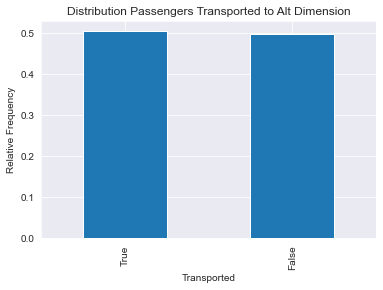

In [42]:
data["Transported"].value_counts(normalize=True).plot(
    kind="bar", xlabel="Transported", ylabel="Relative Frequency", title="Distribution Passengers Transported to Alt Dimension"
);

As we can see the target "Transported" shows that dataset is evenly distributed each one being almost 50% of the entire dataset and most classification models perform well when working with balanced data.

## Modeling

### Initialize PyCaret Environment

In [43]:
class_space = setup(data = data, target = 'Transported', train_size = 0.8,normalize = True, session_id = 3934)

,Description,Value
0,session_id,3934
1,Target,Transported
2,Target Type,Binary
3,Label Encoded,"False: 0, True: 1"
4,Original Data,"(8693, 14)"
5,Missing Values,False
6,Numeric Features,6
7,Categorical Features,7
8,Ordinal Features,False
9,High Cardinality Features,False


In [44]:
get_config("X").head()

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,HomePlanet_Earth,HomePlanet_Europa,HomePlanet_Mars,CryoSleep_False,...,deck_A,deck_B,deck_C,deck_D,deck_E,deck_F,deck_G,deck_T,Side_S,PaxInGroup_True
0,0.713555,-0.334502,-0.277171,-0.278774,-0.270019,-0.255253,0.0,1.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,-0.333488,-0.170123,-0.271750,-0.238524,0.216652,-0.217935,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
2,2.039809,-0.269655,1.876885,-0.278774,5.682616,-0.213695,0.0,1.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
3,0.294737,-0.334502,0.495663,0.318526,2.681034,-0.091563,0.0,1.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
4,-0.891911,0.122442,-0.235006,-0.035668,0.230835,-0.253557,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0


In [45]:
compare_models(sort='Accuracy')

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
catboost,CatBoost Classifier,0.8024,0.8906,0.8190,0.7970,0.8077,0.6046,0.6051,1.4420
lightgbm,Light Gradient Boosting Machine,0.7997,0.8895,0.8173,0.7938,0.8052,0.5991,0.5996,0.2380
gbc,Gradient Boosting Classifier,0.7988,0.8880,0.8394,0.7804,0.8088,0.5972,0.5990,0.1570
xgboost,Extreme Gradient Boosting,0.7941,0.8803,0.8005,0.7950,0.7975,0.5880,0.5884,0.2820
ada,Ada Boost Classifier,0.7923,0.8767,0.8229,0.7798,0.8006,0.5843,0.5856,0.0690
lr,Logistic Regression,0.7905,0.8776,0.8110,0.7836,0.7968,0.5807,0.5816,0.4600
rf,Random Forest Classifier,0.7893,0.8641,0.7554,0.8156,0.7841,0.5790,0.5809,0.1600
svm,SVM - Linear Kernel,0.7823,0.0000,0.8039,0.7775,0.7875,0.5643,0.5686,0.0190
knn,K Neighbors Classifier,0.7764,0.8503,0.7792,0.7796,0.7793,0.5527,0.5529,0.0490
et,Extra Trees Classifier,0.7703,0.8380,0.7236,0.8041,0.7614,0.5412,0.5444,0.1730


In [46]:
model_cat = create_model('catboost', verbose = False)

params = {'iterations': np.arange(100, 1000, 100),
        'max_depth': np.arange(1, 10),
        'learning_rate': np.arange(0.01, 1, 0.01),
        'random_strength': np.arange(0.1, 1.0, 0.1),
        'l2_leaf_reg': np.arange(1, 100),
        'border_count': np.arange(1, 256)}

tuned_model = tune_model(model_cat, optimize = 'Accuracy', fold = 10,
            tuner_verbose = False, search_library = 'scikit-optimize',
            custom_grid = params, n_iter = 50)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.8075,0.8844,0.8215,0.8033,0.8123,0.6147,0.6149
1,0.7960,0.8744,0.8074,0.7939,0.8006,0.5918,0.5919
2,0.8161,0.8985,0.8272,0.8134,0.8202,0.6320,0.6321
3,0.8089,0.8849,0.8244,0.8039,0.8140,0.6176,0.6178
4,0.8101,0.8957,0.8580,0.7865,0.8207,0.6196,0.6223
5,0.8129,0.9085,0.8125,0.8171,0.8148,0.6259,0.6259
6,0.7885,0.8905,0.8324,0.7690,0.7995,0.5764,0.5785
7,0.8115,0.9002,0.8466,0.7947,0.8198,0.6226,0.6240
8,0.8072,0.8882,0.8210,0.8028,0.8118,0.6142,0.6144
9,0.8000,0.8939,0.8210,0.7918,0.8061,0.5997,0.6002


### Making Predictions

Prediction will be made on the validation data (based on the train_test_split) in the PyCaret environment.

In [47]:
predictions = predict_model(tuned_model)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,CatBoost Classifier,0.8051,0.8871,0.8443,0.7778,0.8097,0.6106,0.6127


In [48]:
final_model = finalize_model(tuned_model)
save_model(final_model, 'catboost_classification_model')

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=None,
          steps=[('dtypes',
                  DataTypes_Auto_infer(categorical_features=[],
                                       display_types=True, features_todrop=[],
                                       id_columns=[],
                                       ml_usecase='classification',
                                       numerical_features=[],
                                       target='Transported', time_features=[])),
                 ('imputer',
                  Simple_Imputer(categorical_strategy='not_available',
                                 fill_value_categorical=None,
                                 fill_value_numerical=None,
                                 numeric_...
                 ('rem_outliers', 'passthrough'), ('cluster_all', 'passthrough'),
                 ('dummy', Dummify(target='Transported')),
                 ('fix_perfect', Remove_100(target='Transported')),
                 ('clean_names', Clean_Colum_Names()),
          

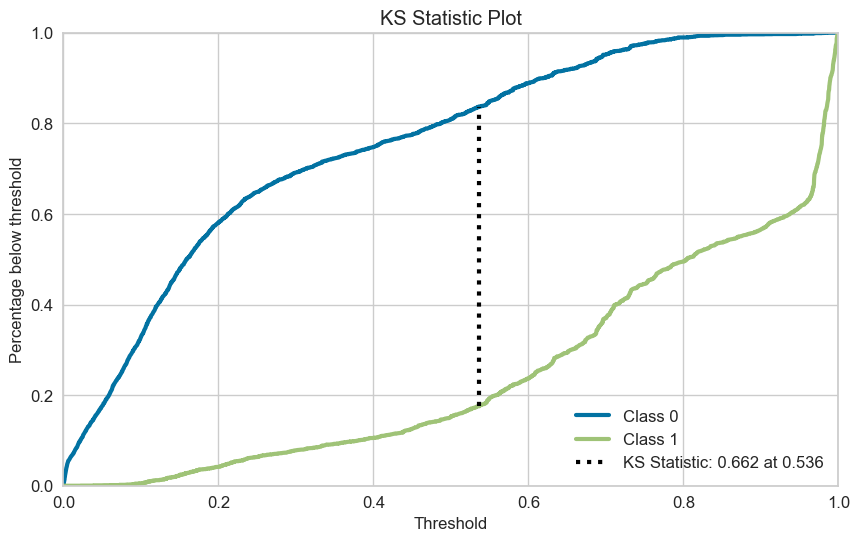

In [49]:
plot_model(final_model, plot = "ks")

#### Predictions on the test dataset

In [50]:
test_data = wrangle("test.csv")
test_data.head()

,PassengerId,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,deck,Side,PaxInGroup
0,0013_01,Earth,True,TRAPPIST-1e,27.0,False,0.0,0.0,0.0,0.0,0.0,G,S,False
1,0018_01,Earth,False,TRAPPIST-1e,19.0,False,0.0,9.0,0.0,2823.0,0.0,F,S,False
2,0019_01,Europa,True,55 Cancri e,31.0,False,0.0,0.0,0.0,0.0,0.0,C,S,False
3,0021_01,Europa,False,TRAPPIST-1e,38.0,False,0.0,6652.0,0.0,181.0,585.0,C,S,False
4,0023_01,Earth,False,TRAPPIST-1e,20.0,False,10.0,0.0,635.0,0.0,0.0,F,S,False


In [51]:
test_predictions = predict_model(final_model, data=test_data)
test_predictions.head()

,PassengerId,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,deck,Side,PaxInGroup,Label,Score
0,0013_01,Earth,True,TRAPPIST-1e,27.0,False,0.0,0.0,0.0,0.0,0.0,G,S,False,True,0.7006
1,0018_01,Earth,False,TRAPPIST-1e,19.0,False,0.0,9.0,0.0,2823.0,0.0,F,S,False,False,0.9817
2,0019_01,Europa,True,55 Cancri e,31.0,False,0.0,0.0,0.0,0.0,0.0,C,S,False,True,0.9977
3,0021_01,Europa,False,TRAPPIST-1e,38.0,False,0.0,6652.0,0.0,181.0,585.0,C,S,False,True,0.9932
4,0023_01,Earth,False,TRAPPIST-1e,20.0,False,10.0,0.0,635.0,0.0,0.0,F,S,False,True,0.6041


In [52]:
submission_final = test_predictions[["PassengerId","Label"]]
print(submission_final.shape)
submission_final.head()

(4277, 2)


,PassengerId,Label
0,0013_01,True
1,0018_01,False
2,0019_01,True
3,0021_01,True
4,0023_01,True


In [53]:
submission_final.to_csv("submission_final.csv", index=False)